# Testing 3 different width-calculation methods

In [1]:
#testing 3 different modes of calculating width:
# 1: default 3-zone (automatic tau correction/phase-normalization)
# 2: fractional 3-zone (automatic tau correction/phase-normalization)
# 3: fractional, no zones

# downsampled the latter 2 (fractional method) by 18 due to slow runtime

# Assuming there are 3 different widths run (Width1, Width2, Width3 columns)

In [2]:
# names of the 3 file extensions: default, frac3, frac0
# ew_stats_default_139470_140170_140270_140965_0 (for example)

In [32]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
import datetime as dt
pd.set_option('display.max_rows', None)


In [4]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs, print_outliers=True):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
    
    if print_outliers:
        print('Removed outlier OBSIDs:', outlier_obs)
        print('Unique observation names:', len(obsdata))
        print()
    return obsdata

def color_outliers(obsdata, outlier_obs):
    #returns df with only the outlier obsids
    #then can plot these in a different color on EW plots
    outlier_obsdata = obsdata.loc[outlier_obs]
    
    return outlier_obsdata

In [5]:
# Define plotting functions (pass in hg_used_data or other similar dataframe)


def trendline(obsdata, x_col, y_col, deg, time_data=False):
    #returns x, y data for trendline for the data vs. time 
    
    
    if time_data:
        #convert dates to floats to be able to use for polyfit (days since first observation)
        obsdata['Time Delta'] = (obsdata[x_col] - obsdata[x_col].min()) \
                                            / np.timedelta64(1,'D')
        x_vals_to_fit = obsdata['Time Delta']
    else:
        x_vals_to_fit = obsdata[x_col]
    
    #calculate + plot the best-fit line (no outliers)
    #calculate best-fit line for EW vs. time data to plot on top
    coeff = np.polyfit(x_vals_to_fit, obsdata[y_col], deg=deg)
    x_min = x_vals_to_fit.min()
    x_max = x_vals_to_fit.max()
    xrange = np.linspace(x_min, x_max, 100)
    
    if time_data:
        xrange_vals = [obsdata[x_col][0]+ dt.timedelta(days = x_days) for x_days in xrange]
    else:
        xrange_vals = xrange
    
    return xrange_vals, np.polyval(coeff, xrange)


# Plot Width vs. PN EW
def width_vs_pn_ew(obsdata, outliers, ew_col='Normal EW3ZPN', width_cols=['Width1', 'Width2', 'Width3'], xlabel='EW (PN, corrected)'):
    
    plt.figure(figsize=(5*len(width_cols),3))
    
    for i in range(len(width_cols)):
        plt.subplot(1, len(width_cols), i+1)
        plt.scatter(obsdata[ew_col], obsdata[width_cols[i]], c='lightseagreen')
        plt.scatter(outliers[ew_col], outliers[width_cols[i]], c='lightcoral', edgecolors='black')
        #plot a trendline
        (x_trend, y_trend) = trendline(obsdata, ew_col, width_cols[i], deg=3)
        plt.plot(x_trend, y_trend, '-', color='black')
        plt.xlabel(xlabel)
        plt.ylabel('Width (km)')
        plt.title('Ring width. vs. '+xlabel+width_cols[i])
    plt.show()   



# Plot Width vs. Time
def width_vs_time(obsdata, outliers, time_col='Date', width_cols=['Width1', 'Width2', 'Width3']):
    
    plt.figure(figsize=(5*len(width_cols),3))
    
    for i in range(len(width_cols)):
        plt.subplot(1, len(width_cols), i+1)
        plt.scatter(obsdata[time_col], obsdata[width_cols[i]], c='indigo', label='regular observations')
        plt.scatter(outliers[time_col], outliers[width_cols[i]], c='lightcoral', edgecolors='black', label='phase curve outliers')
        #plot a trendline
        (x_trend, y_trend) = trendline(obsdata, time_col, width_cols[i], deg=3, time_data=True)
        plt.plot(x_trend, y_trend, '-', color='black')
        plt.xlabel('Time')
        plt.ylabel('Width (km)')
        plt.title('Ring width. vs. Time') #+ width_cols[i])
        plt.legend()
    plt.show()   

    

# Plot Width vs. Prometheus Distance
def width_vs_p_dist(obsdata, outliers, dist_filepath, width_cols=['Width1', 'Width2', 'Width3']):
    
    #read in the datafile with widths for Prometheus
    prometheus_dist = pd.read_csv(dist_filepath, parse_dates=['Date'], index_col='Observation')
    outliers_p_dist = prometheus_dist.copy()

    #remove all obsids in the Prometheus distance data that aren't in the hg_used_data data
    to_remove = []
    to_remove_outliers = []
    for obsid in prometheus_dist.index:
        if obsid not in obsdata.index:
            to_remove.append(obsid)
    prometheus_dist = remove_outliers(prometheus_dist, to_remove)
    
    for obsid in outliers_p_dist.index:
        if obsid not in outliers.index:
            to_remove_outliers.append(obsid)
    outliers_p_dist = remove_outliers(outliers_p_dist, to_remove_outliers, print_outliers=False)

    plt.figure(figsize=(5*len(width_cols),3))
    
    for i in range(len(width_cols)):
        plt.subplot(1, len(width_cols), i+1)
        plt.scatter(prometheus_dist['Prometheus Min Dist'], obsdata[width_cols[i]], c='darkgreen')
        plt.scatter(outliers_p_dist['Prometheus Min Dist'], outliers[width_cols[i]], c='lightcoral', edgecolors='black')
        
        #plot a trendline
        x_vals_to_fit = prometheus_dist['Prometheus Min Dist']
        #calculate + plot the best-fit line (no outliers)
        #calculate best-fit line for EW vs. time data to plot on top
        coeff = np.polyfit(x_vals_to_fit, obsdata[width_cols[i]], deg=3)
        x_min = x_vals_to_fit.min()
        x_max = x_vals_to_fit.max()
        xrange = np.linspace(x_min, x_max, 100)
        x_trend = xrange
        y_trend = np.polyval(coeff, xrange)
        plt.plot(x_trend, y_trend, '-', color='black')
        
        plt.xlabel('Min. Distance from Prometheus')
        plt.ylabel('Width (km)')
        plt.title('Ring width vs. Min. Distance\nfrom Prometheus '+width_cols[i])
    plt.show()
    
    

# Plot Width vs. Mu, Mu0, Phase Angle (should have understandable/no dependence)
def width_vs_viewing_angles(obsdata, outliers, mu_col='Mu', mu0_col='Mu0', phase_col='Mean Phase', width_cols=['Width1', 'Width2', 'Width3']):
    
    plt.figure(figsize=(5*len(width_cols),3))
    for i in range(len(width_cols)):
        plt.subplot(1, len(width_cols), i+1)
        plt.scatter(obsdata[mu_col], obsdata[width_cols[i]], c='coral')
        plt.scatter(outliers[mu_col], outliers[width_cols[i]], c='lightcoral', edgecolors='black')
        #plot a trendline
        (x_trend, y_trend) = trendline(obsdata, mu_col, width_cols[i], deg=1)
        plt.plot(x_trend, y_trend, '-', color='black')
        plt.xlabel('Mu (cos(emission angle))')
        plt.ylabel('Width (km)')
        plt.title('Ring width. vs. Mu '+width_cols[i])
    plt.show()


    plt.figure(figsize=(5*len(width_cols),3))
    for i in range(len(width_cols)):
        plt.subplot(1, len(width_cols), i+1)
        plt.scatter(obsdata[mu0_col], obsdata[width_cols[i]], c='deepskyblue')
        plt.scatter(outliers[mu0_col], outliers[width_cols[i]], c='lightcoral', edgecolors='black')
        #plot a trendline
        (x_trend, y_trend) = trendline(obsdata, mu0_col, width_cols[i], deg=1)
        plt.plot(x_trend, y_trend, '-', color='black')
        plt.xlabel('Mu0 (cos(incidence angle))')
        plt.ylabel('Width (km)')
        plt.title('Ring width. vs. Mu0 '+width_cols[i])
    plt.show()

    plt.figure(figsize=(5*len(width_cols),3))
    for i in range(len(width_cols)):
        plt.subplot(1, len(width_cols), i+1)
        plt.scatter(obsdata[phase_col], obsdata[width_cols[i]], c='midnightblue')
        plt.scatter(outliers[phase_col], outliers[width_cols[i]], c='lightcoral', edgecolors='black')
        #plot a trendline
        (x_trend, y_trend) = trendline(obsdata, phase_col, width_cols[i], deg=1)
        plt.plot(x_trend, y_trend, '-', color='black')
        plt.xlabel('Phase angle')
        plt.ylabel('Width (km)')
        plt.title('Ring width. vs. Phase angle '+width_cols[i])
    plt.show()


In [6]:
# Define variables

# directory of dumped EW csv files
dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'

# path to Prometheus distance file
dist_filepath = '/Users/mlessard/REU_2022/data/prometheus_dist.csv'

#names of extensions for each of the methods
extensions = ['default', 'frac3', 'frac0']

#using the CSV data created with 3 regions or not?
three_region = True

#radii values (three-region)
radii = [139470, 140170, 140265, 140965]

# slice/step size of the csv file, currently only have 0
size = 0

# degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#remove outliers? (not including EQX values)
rm_outliers = False

#nstd to remove for HG param tau fitting
nstd = None

# list outlier obsids
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
#outliers_inner = ['ISS_177RF_FRSTRCHAN001_PRIME_2', 'ISS_201RF_FMOVIE001_PRIME_2', 'ISS_079RF_FRINGMRLF002_PRIME', 'ISS_235RF_FMOVIE001_PRIME']
outliers_outer = []#'ISS_051RI_LPMRDFMOV001_PRIME'] #outlier ~57 phase angle in width vs. phase angle plots
outliers = outliers + ['ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS'] #105 outliers
outliers = outliers + ['ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS'] #85 outliers

ms=20
alpha=0.7

In [7]:
# Read in the CSV files
obsdatas = []
outlier_obsdatas = []

for extension in extensions:
    #get the full-width image data
    
    #(since frac0 has no zones, different filename structure)
    if extension != 'frac0':
        full_img_filepath = f'{dump_ew_dir}ew_stats_{extension}_{radii[0]}_{radii[1]}_{radii[2]}_{radii[3]}_{size}.csv'
    else:
        full_img_filepath = f'{dump_ew_dir}ew_stats_{extension}_{radii[0]}_{radii[3]}_{size}.csv'

    
    full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation')

    #calculate mu, mu0 
    full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
    full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))
    
    ##print initial statistics
    #print('** ORIGINAL SUMMARY STATISTICS **')
    #print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
    #print('Total slices:', len(full_orig_obsdata))
    #print('Starting date:', full_orig_obsdata['Date'].min())
    #print('Ending date:', full_orig_obsdata['Date'].max())
    #print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
    #print()

    #print(full_img_filepath)
    
    #remove EQX observations
    removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)
    
    #get df with just outliers to plot in different color
    outlier_obsdata = color_outliers(removed_eqx_obsdata, outliers)


    #remove outliers
    if rm_outliers:
        obsdata = remove_outliers(removed_eqx_obsdata, outliers)
    else:
        obsdata = removed_eqx_obsdata

    ##print final statistics
    #print('** FINAL SUMMARY STATISTICS **')
    #print('Unique observation names:', len(obsdata.groupby('Observation')))
    #print('Total slices:', len(obsdata))
    #print('Starting date:', obsdata['Date'].min())
    #print('Ending date:', obsdata['Date'].max())
    #print('Time span:', obsdata['Date'].max()-obsdata['Date'].min())
    #print()
    
    # append the procesed obsdata to the list
    obsdatas.append(obsdata)
    outlier_obsdatas.append(outlier_obsdata)

Removed EQX OBSIDs: {'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_115RF_FMOVIEEQX001_PRIME'}
Unique observation names: 145

Removed EQX OBSIDs: {'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_115RF_FMOVIEEQX001_PRIME'}
Unique observation names: 145

Removed EQX OBSIDs: {'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_115RF_FMOVIEEQX001_PRIME'}
Unique observation names: 145



In [8]:
# name each of the obsdatas so it's easier
obsdata_default = obsdatas[0]
obsdata_frac3 = obsdatas[1]
obsdata_frac0 = obsdatas[2]

outliers_default = outlier_obsdatas[0]
outliers_frac3 = outlier_obsdatas[1]
outliers_frac0 = outlier_obsdatas[2]

In [9]:
print(obsdata_default.columns)

Index(['Slice#', 'Num Data', 'Date', 'Min Long', 'Max Long', 'Mean Long',
       'Min Inertial Long', 'Max Inertial Long', 'Mean Inertial Long',
       'Min Long of Pericenter', 'Max Long of Pericenter',
       'Mean Long of Pericenter', 'Min True Anomaly', 'Max True Anomaly',
       'Mean True Anomaly', 'Min Res', 'Max Res', 'Mean Res', 'Min Phase',
       'Max Phase', 'Mean Phase', 'Min Emission', 'Max Emission',
       'Mean Emission', 'Incidence', '% Coverage', 'EW', 'EW Std', 'Normal EW',
       'Normal EW Std', 'EWI', 'EWI Std', 'Normal EWI', 'Normal EWI Std',
       'EWC', 'EWC Std', 'Normal EWC', 'Normal EWC Std', 'EWO', 'EWO Std',
       'Normal EWO', 'Normal EWO Std', 'Normal EW3Z', 'Normal EW3Z Std',
       'Normal EW3ZPN', 'Normal EW3ZPN Std', 'Width1', 'Width1 Std', 'Width2',
       'Width2 Std', 'Width3', 'Width3 Std', 'Width1I', 'Width1I Std',
       'Width1O', 'Width1O Std', 'Width2I', 'Width2I Std', 'Width2O',
       'Width2O Std', 'Width3I', 'Width3I Std', 'Width3O', 

# 1: Default method (3-zone, absolute threshold)

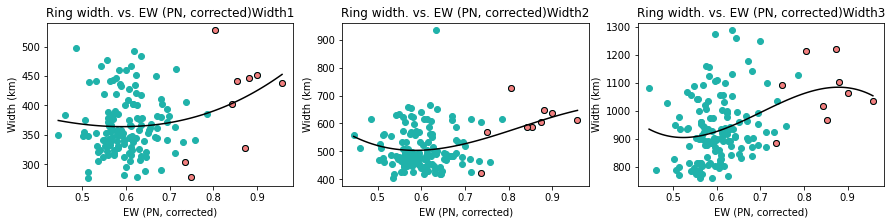

In [10]:
# plot mean width vs. mean normal EW (tau-adjusted, phase-normalized)
width_vs_pn_ew(obsdata_default, outliers_default)

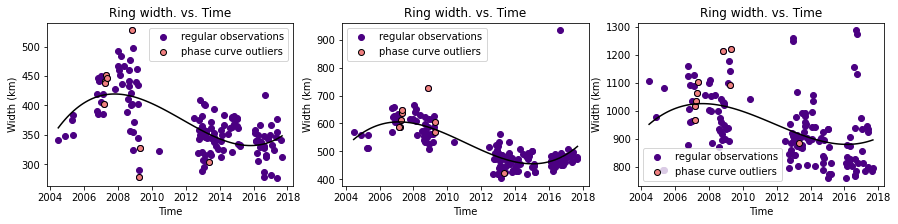

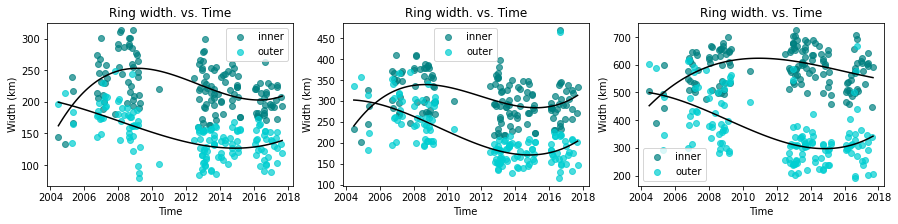

In [11]:
# mean width vs. time
width_vs_time(obsdata_default, outliers_default)


#plot the inner and outer widths vs. time
width_cols = ['Width1', 'Width2', 'Width3']
width_cols_i = ['Width1I', 'Width2I', 'Width3I']
width_cols_o = ['Width1O', 'Width2O', 'Width3O']
time_col = 'Date'

plt.figure(figsize=(5*len(width_cols_i),3))
for i in range(len(width_cols_i)):
    plt.subplot(1, 3, i+1)
    plt.scatter(obsdata_default[time_col], np.abs(obsdata_default[width_cols_i[i]]), c='teal', alpha=0.7, label='inner')
    plt.scatter(obsdata_default[time_col], np.abs(obsdata_default[width_cols_o[i]]), c='darkturquoise', alpha=0.7, label='outer')
    #plot a trendline for each
    (x_trend_i, y_trend_i) = trendline(obsdata_default, time_col, width_cols_i[i], deg=3, time_data=True)
    plt.plot(x_trend_i, np.abs(y_trend_i), '-', color='black')
    (x_trend_o, y_trend_o) = trendline(obsdata_default, time_col, width_cols_o[i], deg=3, time_data=True)
    plt.plot(x_trend_o, y_trend_o, '-', color='black')
    plt.xlabel('Time')
    plt.ylabel('Width (km)')
    plt.title('Ring width. vs. Time') #+ width_cols[i])
    plt.legend()
plt.show() 

Removed outlier OBSIDs: ['ISS_110RF_FMOVIE002_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_168RI_PROPRETRG001_PRIME']
Unique observation names: 145



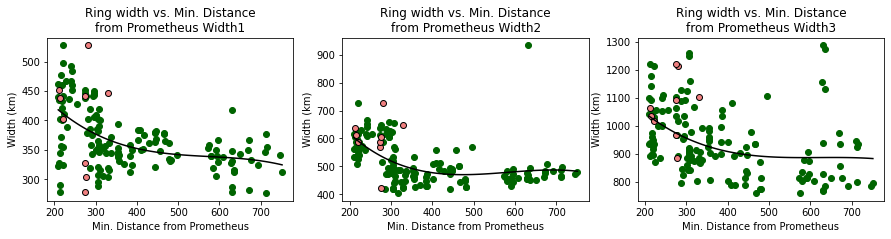

In [12]:
# width vs. minimum distance from Prometheus
width_vs_p_dist(obsdata_default, outliers_default, dist_filepath)

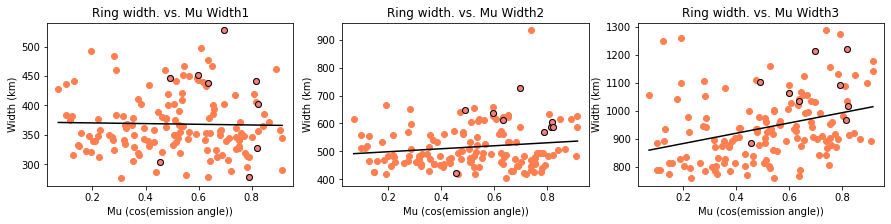

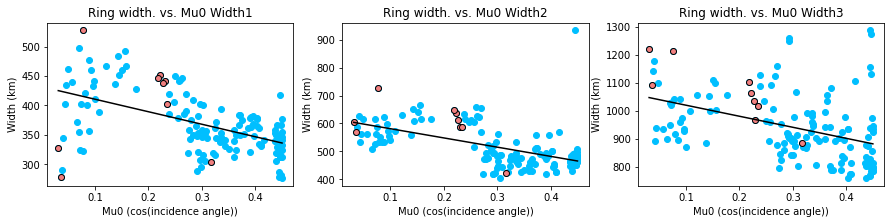

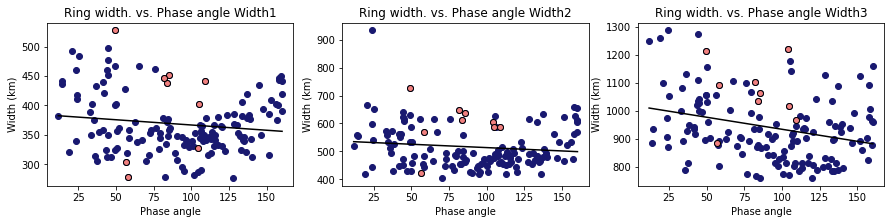

In [13]:
#mean width vs. Mu / Mu0 / Phase angle (make sure there's no residual dependency)
#do for each of the 3 widths
width_vs_viewing_angles(obsdata_default, outliers_default)

# 2: Fractional method (3-zone)

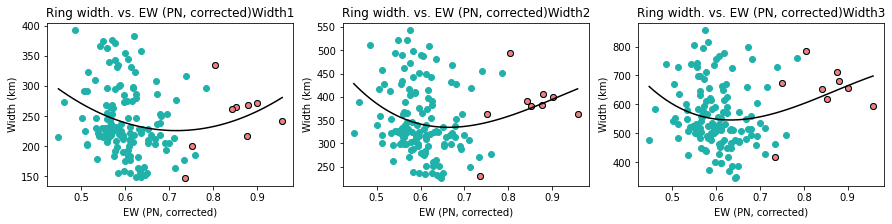

In [14]:
# plot mean width vs. mean normal EW (tau-adjusted, phase-normalized)
width_vs_pn_ew(obsdata_frac3, outliers_frac3)

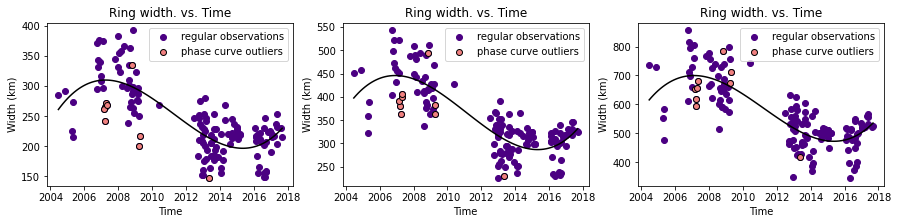

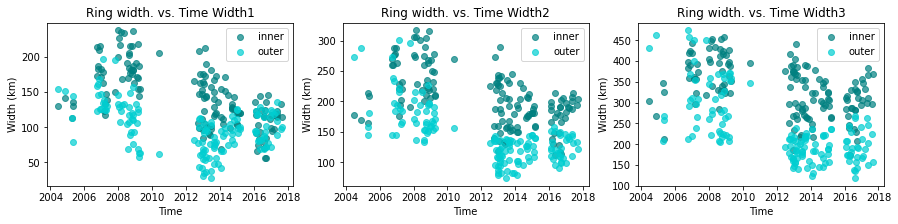

In [15]:
# mean width vs. time
width_vs_time(obsdata_frac3, outliers_frac3)

plt.figure(figsize=(5*len(width_cols_i),3))
for i in range(len(width_cols_i)):
    plt.subplot(1, 3, i+1)
    plt.scatter(obsdata_frac3[time_col], np.abs(obsdata_frac3[width_cols_i[i]]), c='teal', alpha=0.7, label='inner')
    plt.scatter(obsdata_frac3[time_col], np.abs(obsdata_frac3[width_cols_o[i]]), c='darkturquoise', alpha=0.7, label='outer')
    #plt.scatter(outliers[time_col], outliers[width_cols[i]], c='lightcoral', edgecolors='black')
    #plot a trendline
    #(x_trend, y_trend) = trendline(obsdata, time_col, width_cols[i], deg=3, time_data=True)
    #plt.plot(x_trend, y_trend, '-', color='black')
    plt.xlabel('Time')
    plt.ylabel('Width (km)')
    plt.title('Ring width. vs. Time '+ width_cols[i])
    plt.legend()
plt.show() 

Removed outlier OBSIDs: ['ISS_110RF_FMOVIE002_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_168RI_PROPRETRG001_PRIME']
Unique observation names: 145



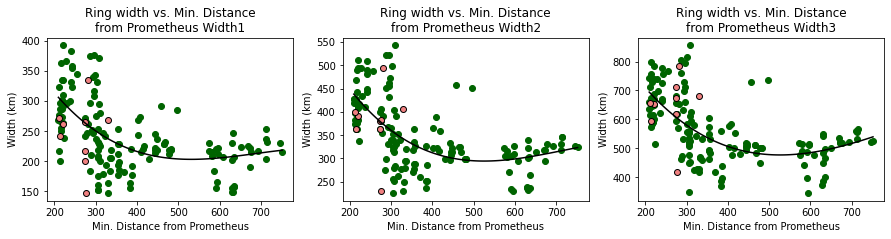

In [16]:
# width vs. minimum distance from Prometheus
width_vs_p_dist(obsdata_frac3, outliers_frac3, dist_filepath)

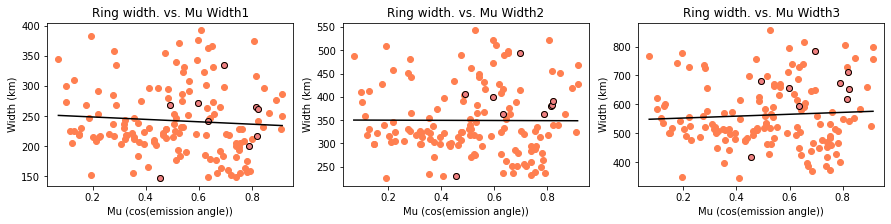

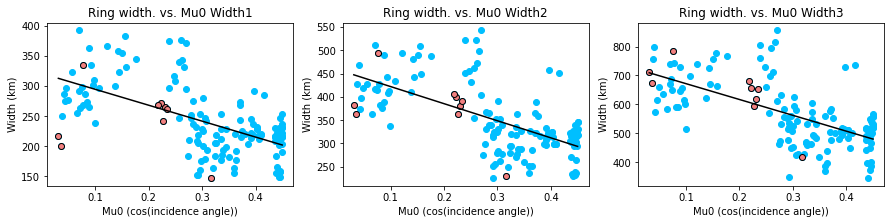

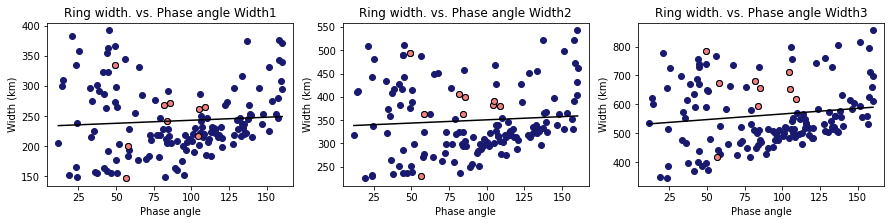

In [17]:
#mean width vs. Mu / Mu0 / Phase angle (make sure there's no residual dependency)
#do for each of the 3 widths
width_vs_viewing_angles(obsdata_frac3, outliers_frac3)

# 3: Fractional method (one-zone, no tau/phase correction)

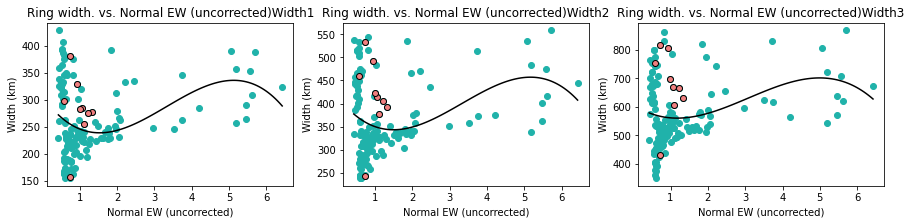

In [18]:
# plot mean width vs. mean normal EW (tau-adjusted, phase-normalized)
width_vs_pn_ew(obsdata_frac0, outliers_frac0, ew_col='Normal EW', xlabel='Normal EW (uncorrected)')

/var/folders/qk/hcd2p1bs6tx9j0t2rkvc281w0000gn/T/ipykernel_26632/1578678969.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obsdata['Time Delta'] = (obsdata[x_col] - obsdata[x_col].min()) \


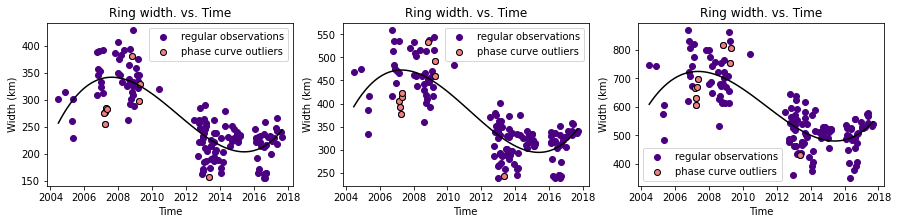

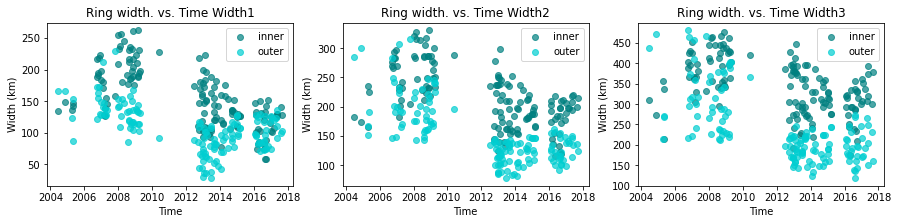

In [19]:
# mean width vs. time
width_vs_time(obsdata_frac0, outliers_frac0)

plt.figure(figsize=(5*len(width_cols_i),3))
for i in range(len(width_cols_i)):
    plt.subplot(1, 3, i+1)
    plt.scatter(obsdata_frac0[time_col], np.abs(obsdata_frac0[width_cols_i[i]]), c='teal', alpha=0.7, label='inner')
    plt.scatter(obsdata_frac0[time_col], np.abs(obsdata_frac0[width_cols_o[i]]), c='darkturquoise', alpha=0.7, label='outer')
    #plt.scatter(outliers[time_col], outliers[width_cols[i]], c='lightcoral', edgecolors='black')
    #plot a trendline
    #(x_trend, y_trend) = trendline(obsdata, time_col, width_cols[i], deg=3, time_data=True)
    #plt.plot(x_trend, y_trend, '-', color='black')
    plt.xlabel('Time')
    plt.ylabel('Width (km)')
    plt.title('Ring width. vs. Time '+ width_cols[i])
    plt.legend()
plt.show() 

Removed outlier OBSIDs: ['ISS_110RF_FMOVIE002_PRIME', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_168RI_PROPRETRG001_PRIME']
Unique observation names: 145



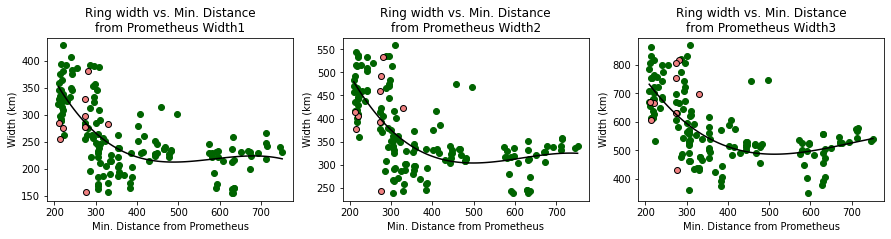

In [20]:
# width vs. minimum distance from Prometheus
width_vs_p_dist(obsdata_frac0, outliers_frac0, dist_filepath)

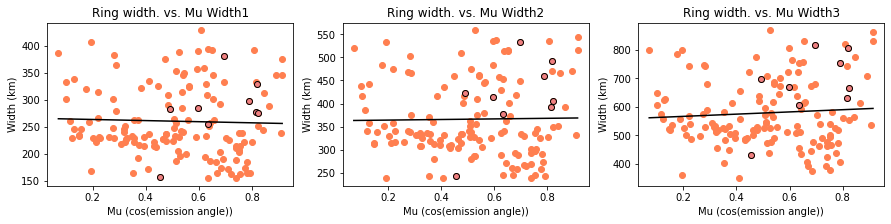

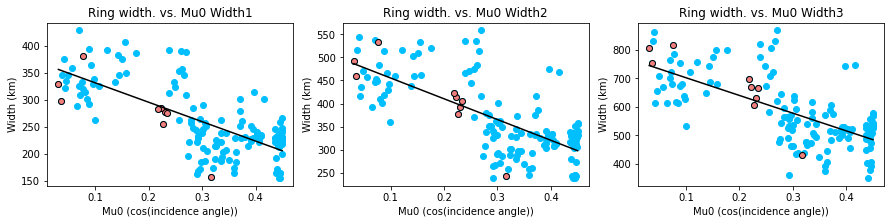

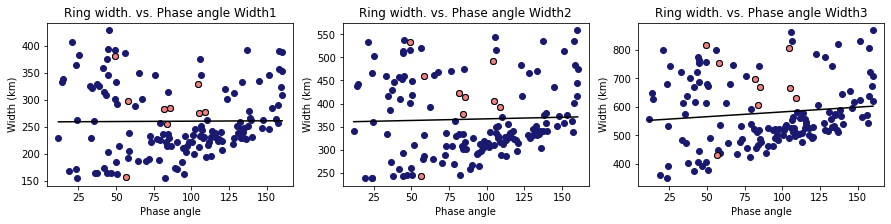

In [21]:
#mean width vs. Mu / Mu0 / Phase angle (make sure there's no residual dependency)
#do for each of the 3 widths
width_vs_viewing_angles(obsdata_frac0, outliers_frac0)

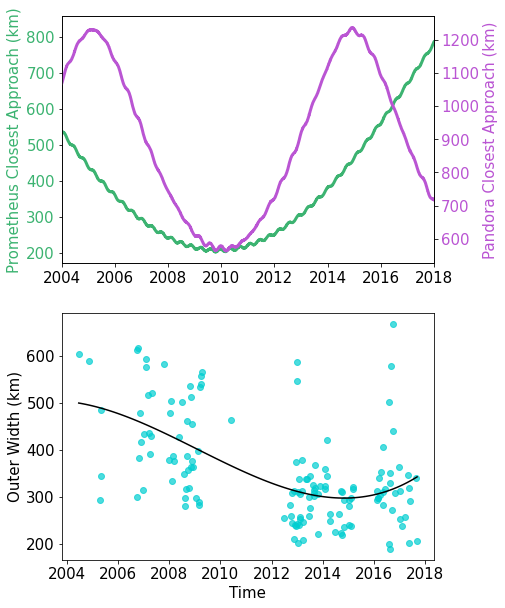

In [37]:
# make the prometheus vs. pandora vs. widths plot (like the EWs one, but including pandora)

data_dir = '/Users/mlessard/REU_2022/data/'

prometheus_data = pd.read_csv(data_dir+'prometheus_historical.csv', parse_dates=['Date'], index_col='Date')
pandora_data = pd.read_csv(data_dir+'pandora_historical.csv', parse_dates=['Date'], index_col='Date')
joint_data = prometheus_data.join(pandora_data, on='Date', how='inner')
joint_data.index = pd.to_datetime([x[:10] for x in joint_data.index])


# plot a 2-section plot with moons distances vs. time on top, EWs w/o outliers on bottom

# plot the moon data
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(6.67,10))

ax = []

#create upper subplot + plot Prometheus moon data
ax.append(plt.subplot(211))
plt.plot(joint_data.index, joint_data['Prometheus Distance'], '-', color='mediumseagreen', lw=3)
plt.yticks(color='mediumseagreen')
plt.ylabel('Prometheus Closest Approach (km)', c='mediumseagreen')

#create plot on secondary y-axis of upper subplot (plot Pandora moon data)
ax.append(ax[0].twinx())
plt.plot(joint_data.index, joint_data['Pandora Distance'], '-', color='mediumorchid', lw=3)
plt.yticks(color='mediumorchid')
plt.ylabel('Pandora Closest Approach (km)', c='mediumorchid')
plt.xlim([dt.date(2004, 1, 1), dt.date(2018, 1, 1)])

#create lower subplot (plot EW data)
time_col = 'Date'
deg=3
#convert dates to time delta to be able to plot trendline
obsdata_default['Time Delta'] = (obsdata_default[time_col] - obsdata_default[time_col].min()) \
                                     / np.timedelta64(1,'D')

ax.append(plt.subplot(212))
#plt.scatter(obsdata_default[time_col], np.abs(obsdata_default[width_cols_i[2]]), c='teal', alpha=0.7, label='inner')
plt.scatter(obsdata_default[time_col], np.abs(obsdata_default[width_cols_o[2]]), c='darkturquoise', alpha=0.7, label='outer')


#plot a trendline for each
#(x_trend_i, y_trend_i) = trendline(obsdata_default, time_col, width_cols_i[2], deg=3, time_data=True)
#plt.plot(x_trend_i, np.abs(y_trend_i), '-', color='black')
(x_trend_o, y_trend_o) = trendline(obsdata_default, time_col, width_cols_o[2], deg=3, time_data=True)
plt.plot(x_trend_o, y_trend_o, '-', color='black')
plt.xlabel('Time')
plt.ylabel('Outer Width (km)')
#plt.ylabel('Inner Width (km)')

#plt.legend()

plt.show()


